<a href="https://colab.research.google.com/github/DesertDemons/Fall_Detection_Template_Using_YOLOv8-pose/blob/main/Fall_Detection_YOLOv8_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#@title # `| Configuration |`
# @markdown ---
# @markdown Choose path of video files
video_file = '/content/video/video.mp4' #@param {type:"string"}
images_dir = '/content/images' #@param {type:"string"}


# @markdown ---
import ipywidgets as widgets
from IPython.display import display
import os
!pip install ultralytics
!pip install cvzone
from IPython import display
display.clear_output()

images = []
count = 0
for dirname, _, filenames in os.walk(images_dir):
    images += filenames
    for filename in filenames:
      if filename.split('.')[-1]=='jpg' or filename.split('.')[-1]=='png' or filename.split('.')[-1]=='jpeg':
        count+=1
        print(os.path.join(dirname, filename))
print('='*40)
print(f'Total number of images = {count}')
print('='*40)


/content/images/fall1.jpg
/content/images/fall4.jpg
/content/images/fall3.jpg
/content/images/fall5.jpg
/content/images/fall2.jpg
Total number of images = 5


##The Logic

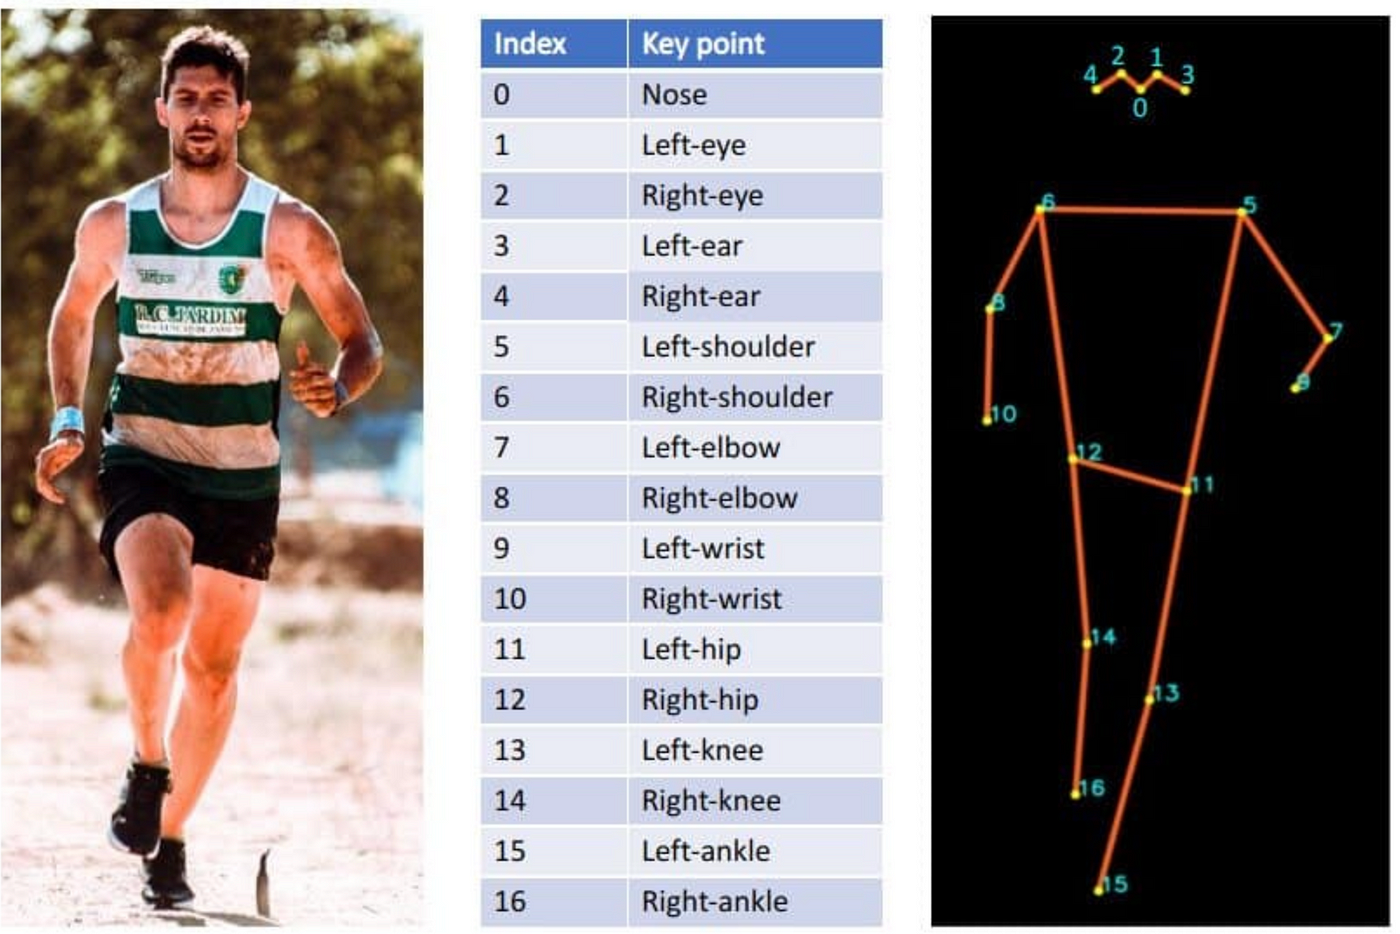

In [ ]:
# COCO Keypoints Mapping
# 0: Nose
# 1: Left Eye
# 2: Right Eye
# 3: Left Ear
# 4: Right Ear
# 5: Left Shoulder
# 6: Right Shoulder
# 7: Left Elbow
# 8: Right Elbow
# 9: Left Wrist
# 10: Right Wrist
# 11: Left Hip
# 12: Right Hip
# 13: Left Knee
# 14: Right Knee
# 15: Left Ankle
# 16: Right Ankle

# In the provided code:
# keypoints[11][:2] refers to the Left Hip.
# keypoints[13][:2] refers to the Left Knee.
# keypoints[15][:2] refers to the Left Ankle.

# YOLO Pose Detection for Fall Detection

# 1. Loading the Model:
# This line loads the YOLO pose estimation model from the specified file.
model = YOLO("yolov8n-pose.pt")

# 2. Defining the Fallen Detection Function:
def is_fallen(keypoints):
    # Extracts the x and y coordinates (horizontal and vertical positions) of the head, hips, and feet.
    head = keypoints[11][:2]
    hips = keypoints[13][:2]
    feet = keypoints[15][:2]

    # Thresholds for determining if head and hips are at similar positions.
    vertical_threshold = 30
    horizontal_threshold = 30

    # Check if head and hips are at similar vertical positions.
    # If the vertical distance between the head and the hips is less than the vertical threshold, it assumes the person has fallen.
    if abs(head[1] - hips[1]) < vertical_threshold:
        return True

    # Check if head and hips are too close horizontally.
    # If the horizontal distance between the head and the hips is less than the horizontal threshold, it assumes the person has fallen.
    if abs(head[0] - hips[0]) < horizontal_threshold:
        return True

    return False

# 3. Image Processing:
# For each image in the specified directory:
# - The image is read and passed to the YOLO model for prediction.
# - Bounding boxes and keypoints for detected persons are extracted.
# - For each detected person, the `is_fallen` function is called with the keypoints to determine if the person has fallen.
# - The result (either "Fallen" or "Standing") is appended to a list of statuses.
# - Bounding boxes and statuses are drawn on the image.
# - The processed image is displayed using `cv2_imshow`.

# Note: The logic used to detect if a person has fallen is based on the assumption that if the
# head and hips are close vertically or horizontally, the person has likely fallen. This might not be accurate for all scenarios,
# especially if the person is sitting or in other non-standing but non-fallen positions. Improving the accuracy would likely require a
# more sophisticated approach, possibly involving multiple keypoints and angles between them.



##Video Fall Detection

In [32]:
import cv2
from ultralytics import YOLO
import numpy as np
import cvzone

# Load a model
model = YOLO("yolov8x-pose.pt")

cap = cv2.VideoCapture('path_to_video_file.mp4')

# Define the codec and create a VideoWriter object to save the output
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_width = 1200
output_height = 680
out = cv2.VideoWriter('posees.mp4', fourcc, 30, (output_width, output_height))

# Define a function to determine if a person has fallen based on keypoints
def is_fallen(keypoints):
    head = keypoints[0][:2]  # Using the nose as a proxy for the head's position
    left_hip = keypoints[11][:2]
    right_hip = keypoints[12][:2]
    left_ankle = keypoints[15][:2]
    right_ankle = keypoints[16][:2]

    # Check if the person's head is closer to the ground than the hips
    if head[1] > left_hip[1] and head[1] > right_hip[1]:
        return True

    # Check if the person's hips are closer to the ground than the ankles
    if left_hip[1] > left_ankle[1] or right_hip[1] > right_ankle[1]:
        return True

    return False

while True:
    ret, frame = cap.read()

    try:
        frame = cv2.resize(frame, (output_width, output_height))
    except:
        pass

    if not ret:
        break

    results = model.predict(frame, save=True)

    # Get the bounding box information in xyxy format
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    statuses = []

    # Get the keypoints data for all detected persons
    keypoints_data = results[0].keypoints.data

    # Iterate through the detected persons
    for i, keypoints in enumerate(keypoints_data):
        # Ensure keypoints are detected
        if keypoints.shape[0] > 0:
            if is_fallen(keypoints):
                print(f"Person {i + 1} has fallen.")
                statuses.append('Fallen')
            else:
                print(f"Person {i + 1} is standing.")
                statuses.append('Standing')

    # Draw bounding boxes and statuses on the frame
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cvzone.putTextRect(
            frame, f"{statuses[i]}", (x1, y2 - 10),
            scale=3, thickness=3,
            colorT=(255, 255, 255), colorR=(255, 0, 255),
            font=cv2.FONT_HERSHEY_PLAIN,
            offset=10,
            border=0, colorB=(0, 255, 0)
        )

    # Write the frame to the output video file
    out.write(frame)

    # Display the resulting frame with pose detection and statuses
    cv2.imshow('YOLOv8 Pose Detection', frame)

    # Exit the program if the user presses the 'q' key
    if cv2.waitKey(1) == ord('q'):
        break

# Release the video capture device, close the output video file, and close the display window
cap.release()
out.release()
cv2.destroyAllWindows()


100%|██████████| 133M/133M [00:01<00:00, 74.1MB/s]


##Single Image Fall Detection


0: 512x640 1 person, 3218.2ms
Speed: 2.8ms preprocess, 3218.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/pose/predict74


Person 1 has fallen.


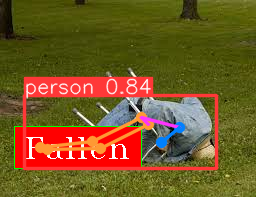

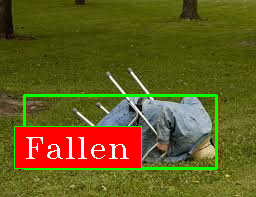

In [99]:
# for one image only
import cv2
from ultralytics import YOLO
import numpy as np
import cvzone
from google.colab.patches import cv2_imshow

# Load a model
model = YOLO("yolov8x-pose.pt")

# Load the image
image_path = '/content/images/fall4.jpg'
image = cv2.imread(image_path)

# Define a function to determine if a person has fallen based on keypoints
def is_fallen(keypoints):
    head = keypoints[11][:2]
    hips = keypoints[13][:2]
    feet = keypoints[15][:2]

    # Threshold for determining if head and hips are at similar vertical positions
    threshold = 30

    # Check if head and hips are at similar vertical positions
    if abs(head[1] - hips[1]) < threshold:
        return True
    return False

results = model.predict(image, save=True)

# Get the bounding box information in xyxy format
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

statuses = []

# Get the keypoints data for all detected persons
keypoints_data = results[0].keypoints.data

# Iterate through the detected persons
for i, keypoints in enumerate(keypoints_data):
    # Ensure keypoints are detected
    if keypoints.shape[0] > 0:
        if is_fallen(keypoints):
            print(f"Person {i + 1} has fallen.")
            statuses.append('Fallen')
        else:
            print(f"Person {i + 1} is standing.")
            statuses.append('Standing')

# Draw bounding boxes and statuses on the image
for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i]
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cvzone.putTextRect(
        image, f"{statuses[i]}", (x1, y2 - 10),  # Image and starting position of the rectangle
        scale=1, thickness=1,  # Font scale and thickness
        colorT=(255, 255, 255), colorR=(0, 0, 255),  # Text color and Rectangle color
        font=cv2.FONT_HERSHEY_TRIPLEX,  # Font type
        offset=10,  # Offset of text inside the rectangle
        border=0, colorB=(0, 255, 0)  # Border thickness and color
    )

# Show the pose detection on the image
detection = results[0].plot()  # Assuming the first value is the image

# Display the resulting image with pose detection and statuses in Colab
cv2_imshow(detection)
cv2_imshow(image)


##Multiple images Fall Detection with Yolov8n-pose


0: 352x640 1 person, 176.8ms
Speed: 2.4ms preprocess, 176.8ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/pose/predict75


Person 1 in fall1.jpg has fallen.


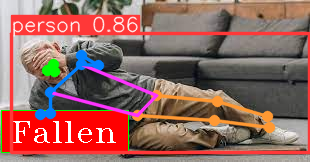

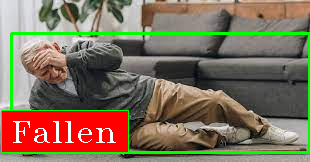


0: 544x640 1 person, 198.8ms
Speed: 3.6ms preprocess, 198.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs/pose/predict75


Person 1 in fall7.jpg has fallen.


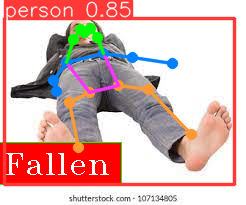

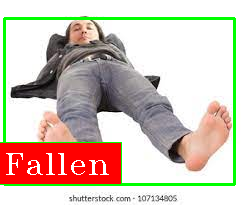


0: 640x640 4 persons, 227.1ms
Speed: 7.9ms preprocess, 227.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/pose/predict75


Person 1 in fall8.jpg is standing.
Person 2 in fall8.jpg has fallen.
Person 3 in fall8.jpg has fallen.
Person 4 in fall8.jpg has fallen.


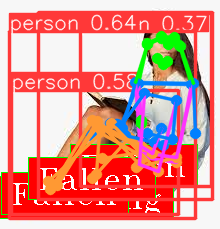

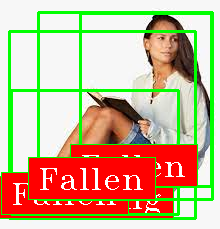


0: 512x640 1 person, 187.4ms
Speed: 3.5ms preprocess, 187.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/pose/predict75


Person 1 in fall4.jpg has fallen.


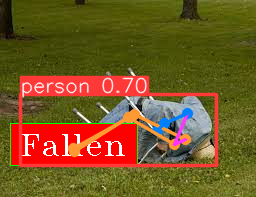

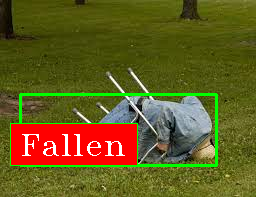


0: 448x640 (no detections), 162.1ms
Speed: 5.1ms preprocess, 162.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/pose/predict75


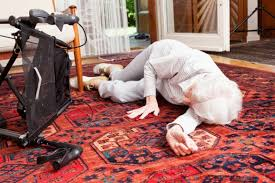

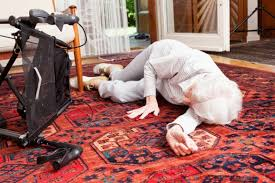


0: 480x640 2 persons, 201.7ms
Speed: 3.9ms preprocess, 201.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/pose/predict75


Person 1 in fall6.jpg has fallen.
Person 2 in fall6.jpg has fallen.


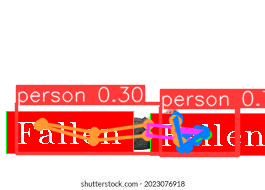

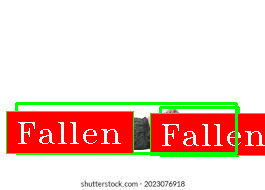


0: 480x640 2 persons, 192.9ms
Speed: 3.2ms preprocess, 192.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/pose/predict75


Person 1 in fall5.jpg is standing.
Person 2 in fall5.jpg has fallen.


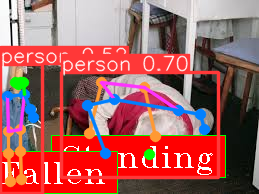

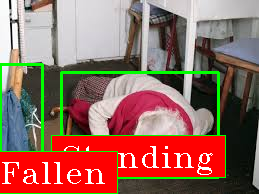


0: 384x640 1 person, 168.5ms
Speed: 3.1ms preprocess, 168.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/pose/predict75


Person 1 in fall2.jpg has fallen.


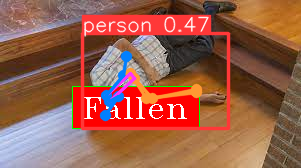

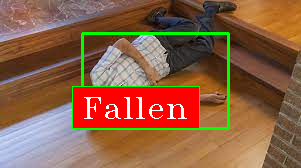

In [100]:
# for set of images in path
import cv2
from ultralytics import YOLO
import numpy as np
import cvzone
from google.colab.patches import cv2_imshow
import os

# Load a model
model = YOLO("yolov8n-pose.pt")

# Define a function to determine if a person has fallen based on keypoints
def is_fallen(keypoints):
    head = keypoints[11][:2]
    hips = keypoints[13][:2]
    feet = keypoints[15][:2]

    # Threshold for determining if head and hips are at similar vertical positions
    threshold = 30

    # Check if head and hips are at similar vertical positions
    if abs(head[1] - hips[1]) < threshold:
        return True
    return False

# Path to the directory containing images
image_directory = images_dir

# List all files in the directory
all_files = os.listdir(image_directory)

# Filter out only image files based on their extensions
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    image = cv2.imread(image_path)

    results = model.predict(image, save=True)

    # Get the bounding box information in xyxy format
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    statuses = []

    # Get the keypoints data for all detected persons
    keypoints_data = results[0].keypoints.data

    # Iterate through the detected persons
    for i, keypoints in enumerate(keypoints_data):
        # Ensure keypoints are detected
        if keypoints.shape[0] > 0:
            if is_fallen(keypoints):
                print(f"Person {i + 1} in {image_file} has fallen.")
                statuses.append('Fallen')
            else:
                print(f"Person {i + 1} in {image_file} is standing.")
                statuses.append('Standing')

    # Draw bounding boxes and statuses on the image
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cvzone.putTextRect(
            image, f"{statuses[i]}", (x1, y2 - 10),  # Image and starting position of the rectangle
            scale=1, thickness=1,  # Font scale and thickness
            colorT=(255, 255, 255), colorR=(0, 0, 255),  # Text color and Rectangle color
            font=cv2.FONT_HERSHEY_TRIPLEX,  # Font type
            offset=10,  # Offset of text inside the rectangle
            border=0, colorB=(0, 255, 0)  # Border thickness and color
        )

    # Show the pose detection on the image
    detection = results[0].plot()  # Assuming the first value is the image

    # Display the resulting image with pose detection and statuses in Colab
    cv2_imshow(detection)
    cv2_imshow(image)


##Higher Accuracy Model to fix issue


0: 704x1280 1 person, 9754.4ms
Speed: 7.4ms preprocess, 9754.4ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1280)
Results saved to runs/pose/predict76


Person 1 in fall1.jpg has fallen.


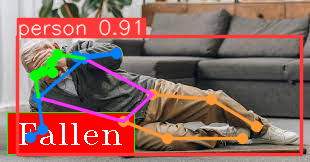

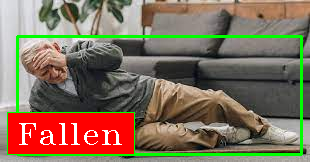


0: 1088x1280 1 person, 14725.4ms
Speed: 11.4ms preprocess, 14725.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1280)
Results saved to runs/pose/predict76


Person 1 in fall7.jpg is standing.


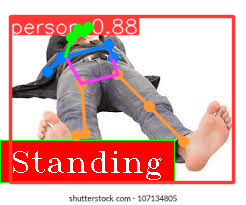

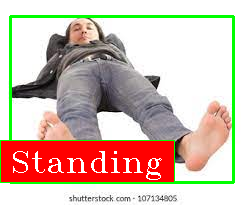


0: 1280x1280 1 person, 17818.4ms
Speed: 13.6ms preprocess, 17818.4ms inference, 2.1ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs/pose/predict76


Person 1 in fall8.jpg is standing.


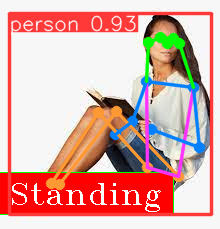

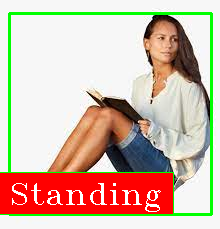


0: 1024x1280 1 person, 13913.5ms
Speed: 12.3ms preprocess, 13913.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1280)
Results saved to runs/pose/predict76


Person 1 in fall4.jpg has fallen.


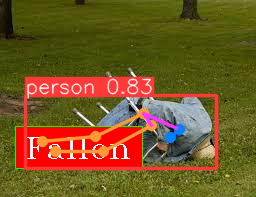

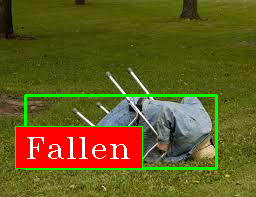


0: 896x1280 1 person, 11932.1ms
Speed: 16.8ms preprocess, 11932.1ms inference, 2.0ms postprocess per image at shape (1, 3, 896, 1280)
Results saved to runs/pose/predict76


Person 1 in fall3.jpg has fallen.


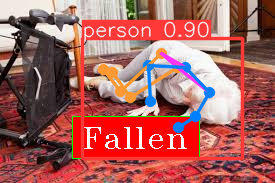

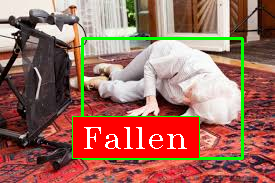


0: 960x1280 1 person, 12702.5ms
Speed: 10.2ms preprocess, 12702.5ms inference, 1.9ms postprocess per image at shape (1, 3, 960, 1280)
Results saved to runs/pose/predict76


Person 1 in fall6.jpg has fallen.


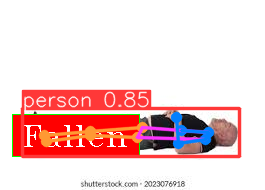

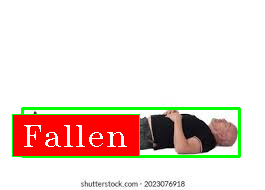


0: 960x1280 1 person, 12758.7ms
Speed: 21.5ms preprocess, 12758.7ms inference, 1.9ms postprocess per image at shape (1, 3, 960, 1280)
Results saved to runs/pose/predict76


Person 1 in fall5.jpg is standing.


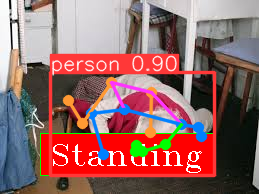

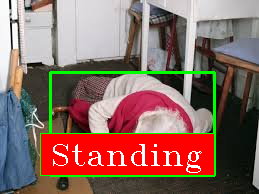


0: 768x1280 1 person, 9549.1ms
Speed: 9.8ms preprocess, 9549.1ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1280)
Results saved to runs/pose/predict76


Person 1 in fall2.jpg has fallen.


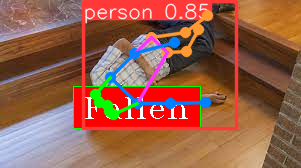

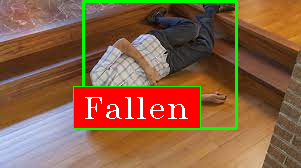

In [101]:
import cv2
from ultralytics import YOLO
import numpy as np
import cvzone
import os
import re
from google.colab.patches import cv2_imshow

# Load a model
model = YOLO("yolov8x-pose-p6.pt")

# Directory containing the set of images
image_directory = images_dir
image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

# Identify the newest "predict" folder within 'runs/pose/'
pose_directory = 'runs/pose'
predict_folders = [d for d in os.listdir(pose_directory) if re.match(r'predict\d+', d)]
# Initialize variables to keep track of the largest number and directory name
largest_number = -1
latest_directory = None

# Iterate through the image_files and find the one with the largest number
for directory in predict_folders:
    try:
        # Extract the number from the directory name
        number = int(directory.replace("predict", ""))

        # Check if this number is larger than the current largest
        if number > largest_number:
            largest_number = number
            latest_directory = directory
    except ValueError:
        # Handle cases where the directory name doesn't contain a valid number
        pass

# Check if a valid latest directory was found
if latest_directory is not None:
    # Construct the full path to the latest directory
    latest_directory_path = os.path.join(image_directory, latest_directory)
newest_folder = os.path.join(pose_directory, max(predict_folders, key=lambda x: int(re.search(r'(\d+)$', x).group(1))))

# Define a function to determine if a person has fallen based on keypoints
def is_fallen(keypoints):
    head = keypoints[11][:2]
    hips = keypoints[13][:2]
    feet = keypoints[15][:2]

    # Threshold for determining if head and hips are at similar vertical positions
    threshold = 30

    # Check if head and hips are at similar vertical positions
    if abs(head[1] - hips[1]) < threshold:
        return True
    return False

# Path to the directory containing images
image_directory = images_dir

# List all files in the directory
all_files = os.listdir(image_directory)

# Filter out only image files based on their extensions
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    image = cv2.imread(image_path)

    results = model.predict(image, save=True)

    # Get the bounding box information in xyxy format
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    statuses = []

    # Get the keypoints data for all detected persons
    keypoints_data = results[0].keypoints.data

    # Iterate through the detected persons
    for i, keypoints in enumerate(keypoints_data):
        # Ensure keypoints are detected
        if keypoints.shape[0] > 0:
            if is_fallen(keypoints):
                print(f"Person {i + 1} in {image_file} has fallen.")
                statuses.append('Fallen')
            else:
                print(f"Person {i + 1} in {image_file} is standing.")
                statuses.append('Standing')

    # Draw bounding boxes and statuses on the image
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cvzone.putTextRect(
            image, f"{statuses[i]}", (x1, y2 - 10),  # Image and starting position of the rectangle
            scale=1, thickness=1,  # Font scale and thickness
            colorT=(255, 255, 255), colorR=(0, 0, 255),  # Text color and Rectangle color
            font=cv2.FONT_HERSHEY_TRIPLEX,  # Font type
            offset=10,  # Offset of text inside the rectangle
            border=0, colorB=(0, 255, 0)  # Border thickness and color
        )

    # Save the processed image in the newest "predict" folder
    output_path = os.path.join(newest_folder, 'processed_' + image_file)
    cv2.imwrite(output_path, image)

    # Show the pose detection on the image
    detection = results[0].plot()  # Assuming the first value is the image

    # Display the resulting image with pose detection and statuses in Colab
    cv2_imshow(detection)
    cv2_imshow(image)


##High Accuracy Larger Model with Condition of horizontal_threshold to check if head and hips are too close horizontally


0: 704x1280 1 person, 8581.0ms
Speed: 8.2ms preprocess, 8581.0ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1280)
Results saved to runs/pose/predict77


Person 1 in fall1.jpg has fallen.


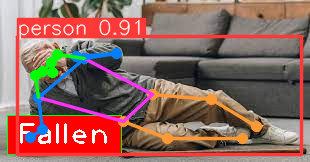

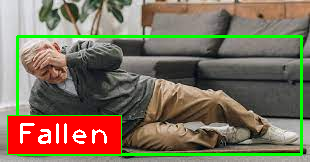


0: 1088x1280 1 person, 15152.1ms
Speed: 12.4ms preprocess, 15152.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1088, 1280)
Results saved to runs/pose/predict77


Person 1 in fall7.jpg is standing.


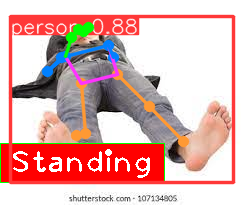

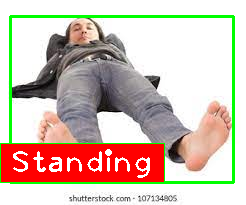


0: 1280x1280 1 person, 17353.3ms
Speed: 13.9ms preprocess, 17353.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs/pose/predict77


Person 1 in fall8.jpg is standing.


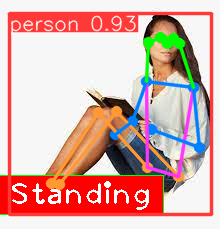

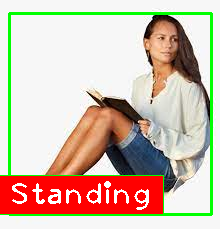


0: 1024x1280 1 person, 13627.3ms
Speed: 17.3ms preprocess, 13627.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1280)
Results saved to runs/pose/predict77


Person 1 in fall4.jpg has fallen.


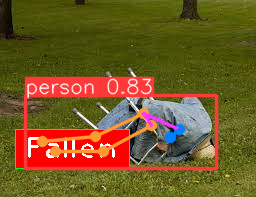

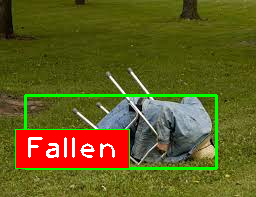


0: 896x1280 1 person, 12113.9ms
Speed: 9.3ms preprocess, 12113.9ms inference, 1.4ms postprocess per image at shape (1, 3, 896, 1280)
Results saved to runs/pose/predict77


Person 1 in fall3.jpg has fallen.


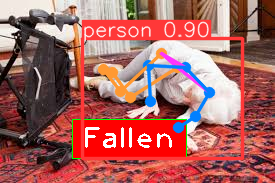

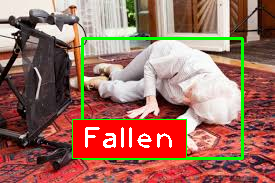


0: 960x1280 1 person, 12853.5ms
Speed: 10.6ms preprocess, 12853.5ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 1280)
Results saved to runs/pose/predict77


Person 1 in fall6.jpg has fallen.


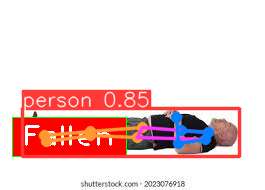

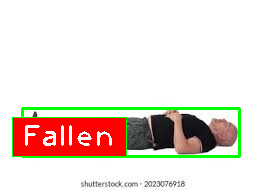


0: 960x1280 1 person, 12917.3ms
Speed: 15.3ms preprocess, 12917.3ms inference, 1.5ms postprocess per image at shape (1, 3, 960, 1280)
Results saved to runs/pose/predict77


Person 1 in fall5.jpg has fallen.


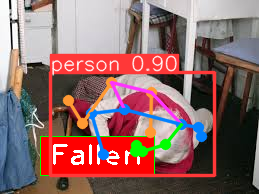

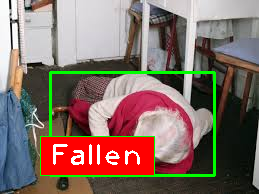


0: 768x1280 1 person, 10490.5ms
Speed: 11.2ms preprocess, 10490.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1280)
Results saved to runs/pose/predict77


Person 1 in fall2.jpg has fallen.


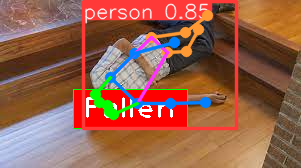

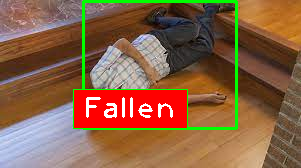

In [102]:
import cv2
from ultralytics import YOLO
import numpy as np
import cvzone
from google.colab.patches import cv2_imshow
import os

# Load a model
model = YOLO("yolov8x-pose-p6.pt")

# Define a function to determine if a person has fallen based on keypoints
def is_fallen(keypoints):
    head = keypoints[11][:2]
    hips = keypoints[13][:2]
    feet = keypoints[15][:2]

    # Thresholds for determining if head and hips are at similar positions
    vertical_threshold = 30
    horizontal_threshold = 30

    # Check if head and hips are at similar vertical positions
    if abs(head[1] - hips[1]) < vertical_threshold:
        return True

    # Check if head and hips are too close horizontally
    if abs(head[0] - hips[0]) < horizontal_threshold:
        return True

    return False

# Path to the directory containing images
image_directory = images_dir

# List all files in the directory
all_files = os.listdir(image_directory)

# Filter out only image files based on their extensions
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    image = cv2.imread(image_path)

    results = model.predict(image, save=True)

    # Get the bounding box information in xyxy format
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    statuses = []

    # Get the keypoints data for all detected persons
    keypoints_data = results[0].keypoints.data

    # Iterate through the detected persons
    for i, keypoints in enumerate(keypoints_data):
        # Ensure keypoints are detected
        if keypoints.shape[0] > 0:
            if is_fallen(keypoints):
                print(f"Person {i + 1} in {image_file} has fallen.")
                statuses.append('Fallen')
            else:
                print(f"Person {i + 1} in {image_file} is standing.")
                statuses.append('Standing')

    # Draw bounding boxes and statuses on the image
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cvzone.putTextRect(
            image, f"{statuses[i]}", (x1, y2 - 10),  # Image and starting position of the rectangle
            scale=2, thickness=2,  # Font scale and thickness
            colorT=(255, 255, 255), colorR=(0, 0, 255),  # Text color and Rectangle color
            font=cv2.FONT_HERSHEY_PLAIN,  # Font type
            offset=10,  # Offset of text inside the rectangle
            border=0, colorB=(0, 255, 0)  # Border thickness and color
        )

    # Show the pose detection on the image
    detection = results[0].plot()  # Assuming the first value is the image

    # Display the resulting image with pose detection and statuses in Colab
    cv2_imshow(detection)
    cv2_imshow(image)
